In [1]:
%matplotlib inline
import pandas as pd
import uproot
import matplotlib.pyplot as plt
import numpy as np
import glob

from dask.distributed import Client, LocalCluster
from yahist import Hist1D, Hist2D

from condor_utils import make_htcondor_cluster

In [11]:
from utils import get_results

In [2]:
cluster = make_htcondor_cluster(dashboard_address=12347)
cluster.scale(16)
cluster

In [36]:
client = Client(cluster)
client

Client Scheduler: tcp://169.228.130.74:29130 Dashboard: http://169.228.130.74:12347/status,Cluster Workers: 4 Cores: 4 Memory: 16.00 GB


In [37]:
fnames = glob.glob("/hadoop/cms/store/user/legianni/ProjectMetis/DoubleEG_Run2017C____x3//*.root")
print(len(fnames))

35


In [38]:
# Takes in a dataframe-like object based on a chunk of a file
# must return a dictionary of things that can be added with `+`
def process(df):
    out = dict()
    out["mycounter"] = len(df)
    out["hmet"] = Hist1D(df["MET_pt"], bins="100,0,1000")
    return out

In [39]:
results = get_results(process, fnames[:5], use_tree_cache=True)

Making chunks for workers



Processing 65 chunks



Processed 6.2812e+06 input events in 4.7s (1340.55kHz)


In [40]:
# use_tree_cache speeds things up the second time you run on the same files (if you're looping on <200 files)
# so we run it again. In principle, `process` can be changed and we'll still see a speedup due to the
# overhead of opening up a nanoaod ttree with uproot
results = get_results(process, fnames[:5], use_tree_cache=True)

Making chunks for workers
Processing 65 chunks



Processed 6.2812e+06 input events in 1.0s (6300.81kHz)


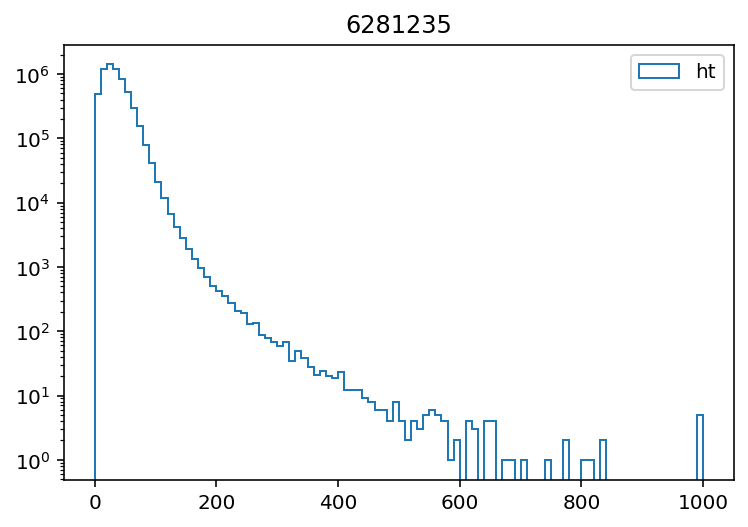

In [41]:
fig, ax = plt.subplots()

results["hmet"].plot(histtype="step", label="ht")

ax.set_title(str(results["mycounter"]))

ax.set_yscale("log")